# Insights into Telco's Churn <a class="tocSkip">

# Goal:  <a class="tocSkip">

- Uncover drivers that are causing Telco customers to churn
- Develop an understanding of possible reasons customers are churning.
- Use machine learning models to predict churn.


# Imports <a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pydataset import data
import os
import env
import acquire 
import prepare

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

 # Acquire <a class="tocSkip">


- Data acquired from SQL DB
- It contained 7043 rows and 23 columns
- Each row represents a customer 
- Each column is a feature that represents a customer's personal info or service they have

# Prepare <a class="tocSkip">

* Prepare Data
    * Remove unneeded data to reduce noise
    * Create new columns utilizing existing data
        * Contract type
        * Online-security 
        * Multiple lines
        * Dependents
    * Rename columns for readability  
    * Create a train, validate, and test dataset with a split of about 56/24/20. 
    
* Explore Data, Answer Questions, Uncover drivers
    * Are customers with month-to-month contracts churning faster than those with 1yr/2yr contracts?
    * Does having online security add-on services affect churn rate?
    * Does having multiple lines affect churn rate?
    * Does having dependents affect churn rate?
    
* Develop machine learning models
    * Utilize drivers in various machine learning models
    * Evaluate and refine models on train and validate data sets
    * Select best performing models
    * Use test data set on best models

# Data Dictionary <a class="tocSkip">

| Feature | Definition |
| :-- | :-- |
| churn | customer who has cancelled their services |
| churn_numeric | churn column encoded |
| contract type | type of contract. Month-to_month, One year, Two year|
| multiple lines | customers with more than one phone line |
| monthly charges | charges due at end of month bill cycle |
| total charges | total amount paid from first day of service |
| online security no internet | online security add-on service with no internet service |
| online security yes_internet | online securtiy add-on service with internet service |
| dependents_no | customers with no dependents |
| dependents_yes | customers with dependents |




In [2]:
# acquire data
telco_df = acquire.get_telco_data()

# preparing the data
telco_df = prepare.prep_telco(telco_df)

# splitting data into train, validate, and test
train, validate, test = prepare.split_data(df=telco_df, target='churn')

# Glance into Telco's data <a class="tocSkip">

In [3]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,multiple_lines_no,multiple_lines_no phone service,multiple_lines_yes,online_security_no,online_security_no internet service,online_security_yes_internet,contract_type_month-to-month,contract_type_one year,contract_type_two year,churn_numeric
5310,7503-MIOGA,Female,1,Yes,No,72,Yes,Yes,Yes,Yes,...,0,0,1,0,0,1,0,0,1,0
3790,5329-KRDTM,Male,1,Yes,No,72,Yes,Yes,No,Yes,...,0,0,1,1,0,0,0,0,1,0
4398,6199-IWKGC,Female,1,Yes,No,46,Yes,Yes,No,No,...,0,0,1,1,0,0,0,1,0,0
2635,3748-FVMZZ,Male,0,No,No,4,No,No phone service,No,No,...,0,1,0,1,0,0,1,0,0,0
2986,4280-DLSHD,Male,0,Yes,No,8,Yes,No,No,Yes,...,1,0,0,1,0,0,1,0,0,0


# Explore <a class="tocSkip">

## How much of Telco's customer base has churned? <a class="tocSkip">

Text(0.5, 1.0, 'Percentage of Churned customers')

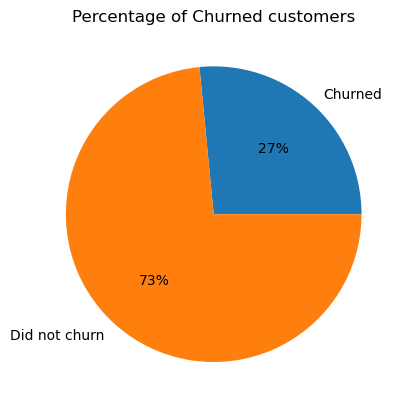

In [5]:
   # set values and labels for chart
x = [len(telco_df.churn[telco_df.churn == 'Yes']), len(telco_df.churn[telco_df.churn == 'No'])] 
labels = ['Churned','Did not churn' ] 

# generate and show chart
plt.pie(x, labels=labels, autopct='%.0f%%')
plt.title('Percentage of Churned customers')


## Are month-to-month contracts churning faster than 1 year or 2 year contracts? <a class="tocSkip">

### Count plot representing contract types of customers<a class="tocSkip">

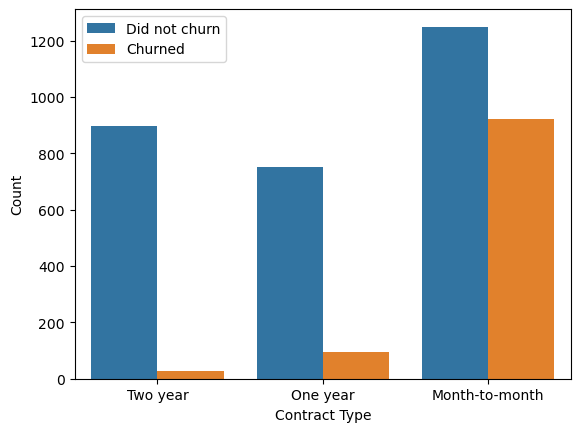

In [6]:
# Count Plot for churn rate of contract types.
sns.countplot(x='contract_type', hue='churn', data=train)
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(['Did not churn', 'Churned'])

- Month-to-month customers seemm to have a higher percentage of churn.

***Chi-square test to see if there is significant difference in churn rates between contract types***

- H0: There is not a significant difference of churn rate and length of contracts.

- Ha: There is a significant difference between churn rate and length of contracts.

- Confidence interval: 95%

- alpha = 0.05

In [7]:
# Variables for contract lengths 
month = train['contract_type']== 'Month-to-month'
oneyear = train['contract_type']== 'One year'
twoyear = train['contract_type']== 'Two year'

# variable for churn
churn = train['churn']

In [8]:
# crosstab for month to month. Crosstab will be inputed into chi-squared algorithm.
mtm_ct = pd.crosstab(churn, month, colnames=['month-to-month'])
mtm_ct

month-to-month,False,True
churn,,
No,1648,1249
Yes,125,921


In [9]:
# Month-to-month
chi, p, degf, expected = stats.chi2_contingency(mtm_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 625.28
p-value: 5.32454352599958e-138


In [10]:
# Crosstab for 1 year churn. Crosstab will be inputed into chi-squared algorithm.
oneyear_ct = pd.crosstab(churn, oneyear, colnames=['one_year'])
oneyear_ct

one_year,False,True
churn,,
No,2144,753
Yes,950,96


In [11]:
# 1 year
chi, p, degf, expected = stats.chi2_contingency(oneyear_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 127.61
p-value: 1.3663034788444405e-29


In [12]:
# Crosstab for 2 year churn. Crosstab will be inputed into chi-squared algorithm.
twoyear_ct = pd.crosstab(churn, twoyear, colnames=['two_year'])
twoyear_ct

two_year,False,True
churn,,
No,2002,895
Yes,1017,29


In [13]:
# 2 year
chi, p, degf, expected = stats.chi2_contingency(twoyear_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 337.16
p-value: 2.6478708937714996e-75


<div class="alert alert-block alert-success">
<b> P-value is lower than 0.05 on all three Chi-square tests<b>
<br>This result shows that there is significant difference in churn rate between month-to-month, one year, and two year contracts <br>
    

## Does having the online security add-on services affect churn rate? <a class="tocSkip">

- H0: There is no significant difference in churn rate when customers have the online security add-on services.

- Ha: There is a significant difference in churn rate when customers have the online security add-on services. 

- Confidence interval = 95%

- alpha = 0.05

In [14]:
# Boolean Mask to remove 'No internet service'
online_sec = train[train['online_security'] != 'No internet service']

### Count plot representing customers with online-security <a class="tocSkip">

<AxesSubplot:xlabel='online_security', ylabel='count'>

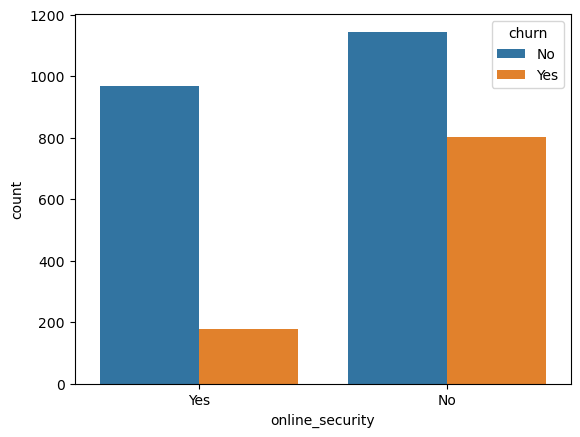

In [15]:
# Countplot for online security churn rate.
sns.countplot(x=online_sec['online_security'], hue=online_sec['churn'], data= online_sec)

In [16]:
# Crosstab for customers with online-security add-on service. Will be input into the chi-square algorithm.
online_sec_ct = pd.crosstab(online_sec['online_security'], online_sec['churn'])
online_sec_ct

churn,No,Yes
online_security,,
No,1145,801
Yes,969,179


In [17]:
# Chi^2 test for Online Security crosstab
chi, p, degf, expected = stats.chi2_contingency(online_sec_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 216.94
p-value: 4.1985954375412895e-49


<div class="alert alert-block alert-success">
<b> P-value is lower than 0.05. <b>
<br>This result shows that there is a signifcant difference in churn rate when customers have online security service. <br>

## Does having multiple lines affect churn rate? <a class="tocSkip">

- H0: There is no signifcant difference in churn rate when customers have multiple lines.

- Ha: There is a significant difference in churn rate when customers have multiple lines.
    
- Confidence interval = 95%

- alpha = 0.05

### Count plot representing churned customers with multiple lines. <a class="tocSkip">



In [18]:
# Boolean Mask to remove 'No phone service'.
mult_lines = train[train['multiple_lines'] != 'No phone service']

<AxesSubplot:xlabel='multiple_lines', ylabel='count'>

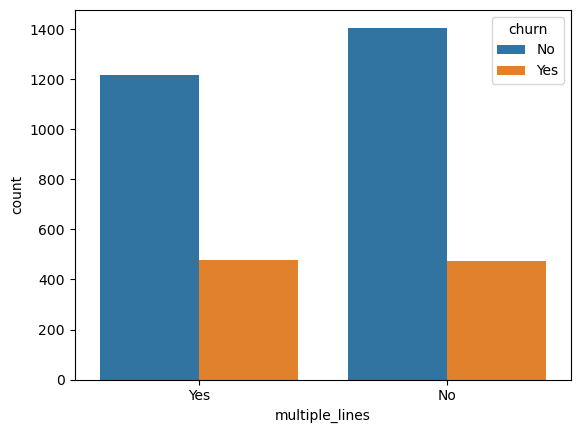

In [19]:
# Count Plot for multiple line churn rate.
sns.countplot(x='multiple_lines', hue='churn', data=mult_lines)

In [20]:
# Crosstab for customers with multiple lines. Will be input into the chi-square algorithm.
mult_lines_ct = pd.crosstab(mult_lines['multiple_lines'], mult_lines['churn'])
mult_lines_ct

churn,No,Yes
multiple_lines,,
No,1406,475
Yes,1218,479


In [21]:
chi, p, degf, expected = stats.chi2_contingency(mult_lines_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 3.88
p-value: 0.048747217941123785


<div class="alert alert-block alert-success">
<b> P-value is lower than 0.05. <b>
<br>This result shows that there is a signifcant difference in churn rate when customers have multiple lines.<br>

## Does having dependents affect churn rate? <a class="tocSkip">

- H0: There is no significant difference in churn rate when customers have dependents.

- Ha: There is a significant difference in churn rate when customers have dependents.
    
- Cofidence interval = 95%

- alpha = 0.05

### Count plot representing customers who have dependents <a class="tocSkip">

<AxesSubplot:xlabel='dependents', ylabel='count'>

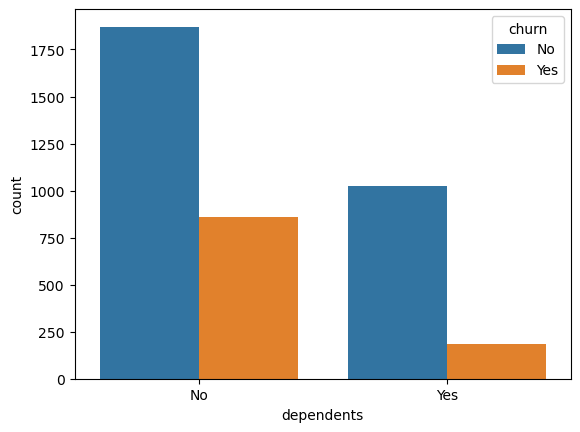

In [22]:
# Countplot for dependents and churn rate 
sns.countplot(x='dependents', hue='churn', data=train)

In [23]:
# Crosstab for customers with dependents. Will be input into the chi-square algorithm.
deps_ct = pd.crosstab(train.dependents, train.churn)
deps_ct

churn,No,Yes
dependents,,
No,1871,859
Yes,1026,187


In [24]:
chi, p, degf, expected = stats.chi2_contingency(deps_ct)
print('Chi-square Test Results')
print('-----------------------')
print(f'Chi value: {round(chi,2)}')
print(f'p-value: {p}')

Chi-square Test Results
-----------------------
Chi value: 110.16
p-value: 9.030713272299022e-26


<div class="alert alert-block alert-success">
<b> P-value is lower than 0.05. <b>
<br>This result shows that there is a significant difference in churn rate when customers have dependents.<br>

## Exploration Summary <a class="tocSkip">

- "Contract types" will be considered as drivers of churn
- Having "online-security" as a service  will be considered as a driver for churn.
- Having "multiple lines" will be considered as a driver for churn.
- Having "dependents" will be considered as a driver for churn.

## Features that will be used in modeling <a class="tocSkip">

- "Contract types" ( Month-to-month, 1 year, 2 year)
- "Online-security" (add-on service)
- "Multiple lines" (more than one phone line)
- "Dependents" (whether customer has dependents or not)

# Machine Learning Models <a class="tocSkip">

- Accuracy score will be the evaluation metric
- Churned customers is about 27%. Non-churned customers is about 73%. 

**-Guessing that a customer churned has a 73% chance of being correct. This will be the baseline**

**-Four different models will be used: Decision Tree, Random Forest, KNN, Logistic Regression.**

**-Model that performs best will move on to the test dataset**

In [25]:
# Dropping all 'Object' dtypes
train = train.select_dtypes(exclude=['object'])
validate = validate.select_dtypes(exclude=['object'])
test= test.select_dtypes(exclude=['object'])

In [26]:
# prep for modeling
X_train = train.drop(['churn_numeric'], axis=1)
y_train = train.churn_numeric

X_validate = validate.drop(['churn_numeric'], axis=1)
y_validate = validate.churn_numeric

X_test = test.drop(['churn_numeric'], axis=1)
y_test = test.churn_numeric

## Decision Tree Model <a class="tocSkip">

In [27]:
# Create Decision Tree Model Object
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
# Fit Decision Tree Model
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [28]:
train_clf = clf.score(X_train,y_train)
val_clf = clf.score(X_validate, y_validate)
print('Decision Tree Results')
print('---------------------')
print(f'Decision Tree Accuracy on train data: {round(train_clf,5)}')
print(f'Decision Tree Accuracy on validate data: {round(val_clf,5)}')
print('Difference:',round(train_clf - val_clf,5))

Decision Tree Results
---------------------
Decision Tree Accuracy on train data: 0.79686
Decision Tree Accuracy on validate data: 0.7877
Difference: 0.00916


## Random Forest <a class="tocSkip">

In [29]:
# Creating Random Forest Model
rf = RandomForestClassifier(max_depth=7, min_samples_leaf=2, random_state=123)
# Fitting the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, random_state=123)

In [30]:
train_rf = rf.score(X_train,y_train)
val_rf = rf.score(X_validate, y_validate)
print('Random Forest Results')
print('---------------------')
print(f'Random Forest Accuracy on train data: {round(train_rf,5)}')
print(f'Random Forest Accuracy on validate data: {round(val_rf,5)}')
print('Difference:',round(train_rf - val_rf,5))

Random Forest Results
---------------------
Random Forest Accuracy on train data: 0.81156
Random Forest Accuracy on validate data: 0.80485
Difference: 0.00672


## KNN <a class="tocSkip">

In [31]:
# Creating KNN Object
knn = KNeighborsClassifier(n_neighbors=35, weights='uniform')
# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=35)

In [32]:
train_knn = knn.score(X_train,y_train)
val_knn = knn.score(X_validate, y_validate)
print('KNN Results')
print('-----------')
print(f'KNN on train data: {round(train_knn,5)}')
print(f'KNN on validate data: {round(val_knn,5)}')
print('Difference:',round(train_knn - val_knn,5))

KNN Results
-----------
KNN on train data: 0.79838
KNN on validate data: 0.78297
Difference: 0.01541


## Logistic Regression <a class="tocSkip">

In [33]:
# Logistic Regression Model Object
logit = LogisticRegression(random_state=123, penalty='l2', max_iter=100, solver='liblinear')
# Fit the model
logit.fit(X_train, y_train)

LogisticRegression(random_state=123, solver='liblinear')

In [34]:
train_logit = logit.score(X_train, y_train)
val_logit = logit.score(X_validate, y_validate)
print('Logistic Regression Results')
print('---------------------------')
print(f'Logistic Regression on train data: {round(train_logit,5)}')
print(f'Logistic Regression on validate data: {round(val_logit,5)}')
print('Difference:',round(train_logit - val_logit,5))

Logistic Regression Results
---------------------------
Logistic Regression on train data: 0.79254
Logistic Regression on validate data: 0.79894
Difference: -0.00639


### Comparing Models <a class="tocSkip">

- Decision Tree and Random Forest performed really well and had similar results. Random Forest model performs slightly better
- KNN model performed okay.
- Logistic Regression performed the worse.
- I have chosen to move forward with the Random Forest model

## Random Forest on Test data <a class="tocSkip">

#### Accuracy score with Test data <a class="tocSkip">


In [35]:
test_rf = rf.score(X_test, y_test)
print(f'Radom Forest on Test data: {round(test_rf,5)}')

Radom Forest on Test data: 0.79702


<div class="alert alert-block alert-success">
<b> Random Forest accuracy is  79.7%. <b>


# Conclusions <a class="tocSkip">

### Exploration <a class="tocSkip">

- About 3 of every 10 customers have churned.
- Customers with month-to-month contracts are more likely to churn
- Customers with online_security are less likely to churn
- Customers with multiple lines are less likely to churn.
- Customers that have dependents are less likely to churn.

### Modeling <a class="tocSkip">

- The final model was able to perform about 7% better than the baseline with about an 80% accuracy.
- Baseline: 73%
- Random Forest: 79.7%

### Recommendations <a class="tocSkip">

- To decrease chance of a customer churning, upsell the importance of having online-security.

### Next Steps <a class="tocSkip">

- Test other add-on services to see if they influence the chance of a customer churning.
- Check if monthly charges of contract types affect churn rate.